In [ ]:
# @title Load data from Kaggle

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T231207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D65140b1d2a00b9d30673e921c388b55fa4bc822ffc86db4402f5d582776ffeebb524b82249e4f060ee31c746410ec613e9bb79a97dca7df20d911391c4975d849d4d03120b74c8a4dce56a69a49436bbacda1c01badaccd0b720d5c517ee4a6a3a4d81653da4d3faee0052cdd016428d75d25db8d135139a8af2f911808efea7b1e9c524c95876a6f86edb865bc610c11c749f95e3c24fa9a7bbf768b1cfacb9c72167c0f072c1d09d7c77ae86ccaef744d50bc48e942a787e6df6130ee2c48a53d3c39c8ffdcdc036a941aa13d692ab08349527f6f3e7abe17dd9ab14bdd7f7e0c6d4a6c726172a378cace2b6171313e7fe82ec2711286258a8ebe8e97965ea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


### Create Dataloaders for training, test and validation data

In [ ]:
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 10.5 MB/s eta 0:00:00


In [ ]:
train_transforms =  transforms.Compose([
                    transforms.Grayscale(),
                    transforms.RandomRotation(30),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Resize((128, 128))
                    ])
test_transforms =   transforms.Compose([
                    transforms.Grayscale(),
                    transforms.ToTensor(),
                    transforms.Resize((128,128))
                    ])
dataset_train = ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/",
                           transform=train_transforms)
dataset_test = ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/",
                         transform=test_transforms)
dataset_val = ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/",
                         transform=test_transforms)

dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

###Visualize a sample from data

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


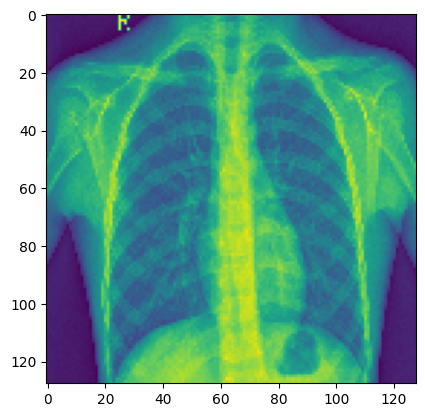

tensor(0)


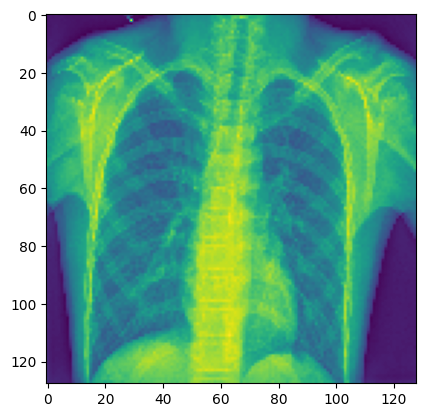

tensor(0)


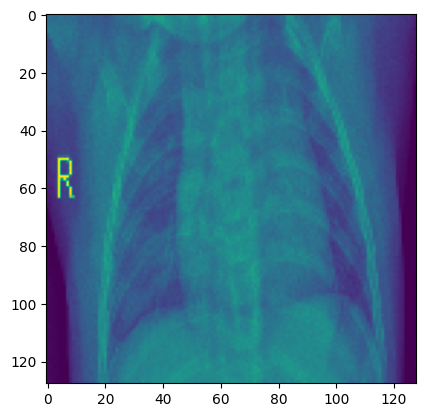

tensor(0)


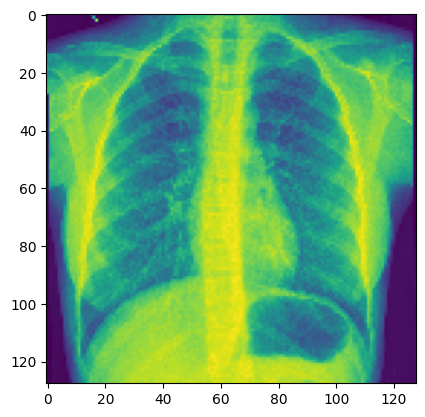

tensor(0)


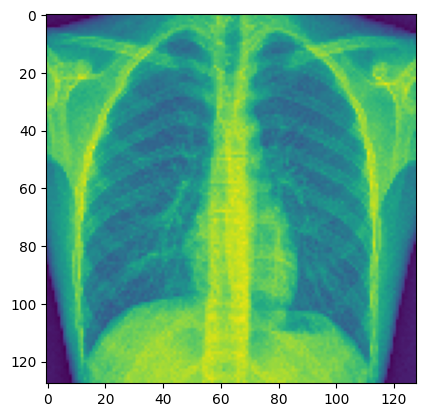

tensor(0)


In [ ]:
import matplotlib.pyplot as plt

len(dataset_train), len(dataset_test)
print(dataset_train[300][0])

for i, (images, labels) in enumerate(dataloader_test):
    img = images[0].squeeze()
    plt.figure()
    plt.imshow(img)
    plt.show()
    print(labels[0])

    if i == 4:
        break



###Define the model

In [ ]:
import torch
from torch import nn

class Net(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.FeatureExtractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )

        self.Classifier = nn.Sequential(
            nn.Linear(16*16*16, 64),
            nn.ELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.FeatureExtractor(x)
        x = self.Classifier(x)
        return x


###Loss function and optimizer, switch to GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Net().to(device)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


cuda:0


###Function, evaluating the model accuracy through the test set

In [ ]:
from torchmetrics import Accuracy

def ModelEval(net, dataloader_test):
    acc = Accuracy(task="binary").to(device)
    loss_avg=[]
    criterion2 = nn.BCELoss().to(device)

    net.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            preds = (outputs >= 0.5).float().squeeze()
            acc(preds, labels)
            loss = criterion(outputs.squeeze(), labels.float())

            """if i%32 == 0:
                print(np.mean(loss_avg))
                loss_avg=[]"""
    accuracy_mean = acc.compute().item()
    print("Test Accuracy:", accuracy_mean)
    net.train()
    return accuracy_mean

###Train the model, evaluate in the process

In [ ]:
loss_avg = []
loss_total = []
accuracy = []
for epoch in range(2):
    print(f"Epoch {epoch+1}:")
    for i, (images, labels) in enumerate(dataloader_train):
        #print(labels)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        #print(outputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        loss_avg.append(loss.item())
        if i%64 == 0:
            print("Mean Loss: ", np.mean(loss_avg))
            loss_total.append(np.mean(loss_avg))
            loss_avg = []
            acc = ModelEval(net, dataloader_test)
            accuracy.append(acc)
            #print(outputs, labels)

print("Mean Loss: ", np.mean(loss_avg))
loss_total.append(np.mean(loss_avg))
loss_avg = []
acc = ModelEval(net, dataloader_test)
accuracy.append(acc)
#print(outputs, labels)


Epoch 1:
Mean Loss:  0.6976840496063232
Test Accuracy: 0.625
Mean Loss:  0.5604404181940481
Test Accuracy: 0.7724359035491943
Mean Loss:  0.32467074308078736
Test Accuracy: 0.7564102411270142
Mean Loss:  0.27531014240230434
Test Accuracy: 0.7291666865348816
Mean Loss:  0.302737633624929
Test Accuracy: 0.8092948794364929
Mean Loss:  0.2040407802342088
Test Accuracy: 0.7820512652397156
Mean Loss:  0.2095710899156984
Test Accuracy: 0.7259615659713745
Mean Loss:  0.229516535437142
Test Accuracy: 0.8413461446762085
Mean Loss:  0.18902749357221182
Test Accuracy: 0.8637820482254028
Mean Loss:  0.17994916308452957
Test Accuracy: 0.7676281929016113
Mean Loss:  0.1618951509044564
Test Accuracy: 0.8381410241127014
Epoch 2:
Mean Loss:  0.2299636835232377
Test Accuracy: 0.7868589758872986
Mean Loss:  0.11357919895817759
Test Accuracy: 0.7724359035491943
Mean Loss:  0.19993878935201792
Test Accuracy: 0.7740384340286255
Mean Loss:  0.1633785262783931
Test Accuracy: 0.7724359035491943
Mean Loss:  0.13

###Plot how the Loss and Accuracy were changing

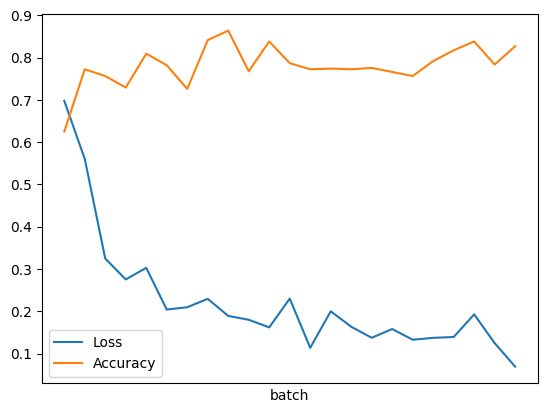

In [ ]:
plt.figure()
plt.plot(loss_total, label="Loss")
plt.plot(accuracy, label="Accuracy")
plt.xlabel("batch")
plt.xticks([])
plt.legend()
plt.show()

###Final Accuracy

In [ ]:
final_accuracy = ModelEval(net, dataloader_test)

Test Accuracy: 0.8269230723381042
